In [ ]:
#@title **Information**
%%html
<marquee style='width: 50%; color: white;'><b>Dylan Govender (221040222) - COMP700</b></marquee>

## **Abstract**

Lung cancer is a significant contributor to cancer-related mortality. With recent advancements in Computer Vision, Vision Transformers have gained traction and shown remarkable success in medical image analysis. This study explores the potential of Vision Transformer models (ViT, CvT, Parallel-ViT, CCT ViT) compared to established state-of-the-art architectures (CNN) for lung cancer detection via medical imaging modalities, including CT scans and X-rays. This work will evaluate the impact of data availability and different training approaches on model performance. The training approaches considered include but are not limited to Supervised Learning and Transfer Learning. Established evaluation metrics such as accuracy, recall, precision, F1-score, and area under the ROC curve (AUC-ROC) will assess model performance in detection efficacy, data validity, and computational efficiency. Cost-sensitive evaluation metrics such as cost matrix and weighted loss will analyse model performance by considering the real-world implications of different types of errors, especially in cases where misdiagnosing a cancer case is more critical.

## **Vision Transformer from Scratch on Lung Cancer CT Scan Images**

In this notebook, we are going to train various Vision Transformer (ViT) Models (including interesting variants) from scratch on the [The IQ-OTH/NCCD lung cancer dataset](https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/code). This dataset contains a total of 1190 images representing CT scan slices of 110 lung cancer cases. These cases are grouped into three classes: normal, benign, and malignant. Of these, 40 cases are diagnosed as malignant; 15 cases diagnosed with benign; and 55 cases classified as normal cases.

We will prepare the data using [The IQ-OTH/NCCD lung cancer dataset](https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/code), and train the model using [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning).

## **Quick Introduction: Vision Transformer (ViT) by Google Brain**

The Vision Transformer (ViT) is basically BERT, but applied to images. This research will see how the ViT compares to state-of-the-art (SOTA) CNN Models. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. Additionally, we can add a [CLS] token at the beginning of the sequence in order to classify images. Next, we can add an absolute position embedding which provides this sequence to the Transformer Encoder.


* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer

## 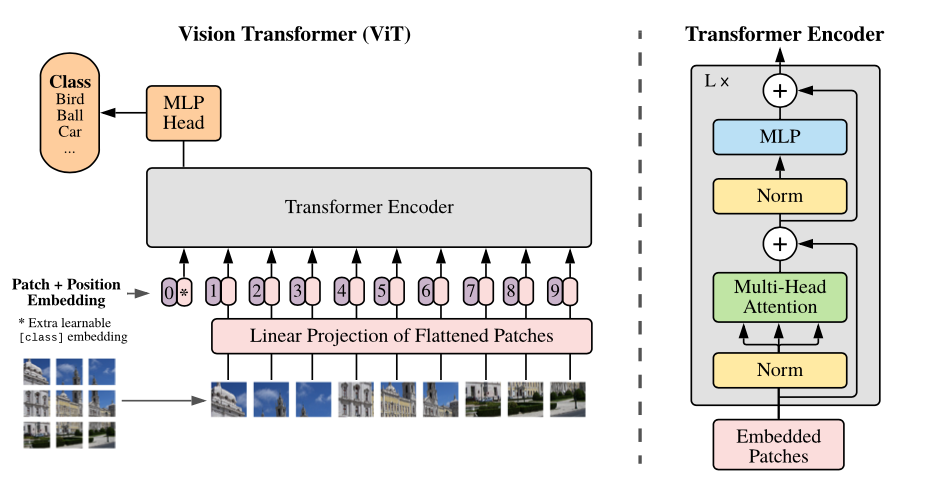


# **1. Downloading Dependencies and Data**

In [ ]:
#@title **1.1 Downloading Dependencies**

# for capturing output
%%capture

# Dependencies
!pip install transformers
!pip install datasets
!pip install pytorch-lightning
!pip install torchmetrics

In [ ]:
#@title **1.2 Downloading Data**

# for capturing output
%%capture

# Data
!cp '/content/drive/MyDrive/Honours Project/Datasets/IQ-OTHNCCD_Lung_Cancer_Dataset.zip' 'IQ-OTHNCCD_Lung_Cancer_Dataset.zip'
!unzip '/content/IQ-OTHNCCD_Lung_Cancer_Dataset.zip'
!rm '/content/IQ-OTHNCCD_Lung_Cancer_Dataset.zip'

# **2. Importing the Data**

In [ ]:
#@title **2.1 Extracting the data.**

import os
import pandas as pd
import matplotlib.pyplot as plt

normal_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Normal cases"
benign_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
malignant_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Malignant cases"
dir = [normal_dir, benign_dir, malignant_dir]

classes = ['benign', 'malignant', 'normal']

labels = []
filepaths = []

for i, directory in enumerate(dir):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        filepaths.append(filepath)
        labels.append(classes[i])

file_series = pd.Series(filepaths, name="filepaths")
label_series = pd.Series(labels, name="labels")
lung_data = pd.concat([file_series, label_series], axis=1)
df = pd.DataFrame(lung_data)
df.head()

,filepaths,labels
0,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
1,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
2,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
3,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
4,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign


Counter({'normal': 561, 'benign': 416, 'malignant': 120})


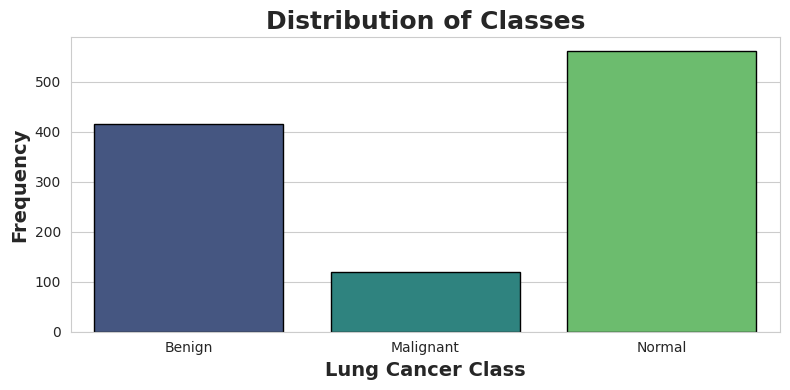

In [ ]:
#@title **2.2 Plotting the Lung Cancer Distribution Graph**

import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SIZE = (8, 4)

def plot_distribution(df, attribute, title, x_label, y_label, size=SIZE):
    # set a seaborn style for a more polished look
    sns.set_style("whitegrid")

    # adjust figure size
    plt.figure(figsize=size)

    # create the count plot with enhanced color palette and edge color
    sns.countplot(x=attribute, data=df, hue=attribute, palette="viridis", edgecolor='black', legend=False)

    # set labels and title with customized font sizes
    plt.xticks(ticks=plt.gca().get_xticks(), labels=[label.get_text().capitalize() for label in plt.gca().get_xticklabels()])
    plt.xlabel(x_label, fontsize=14, fontweight='bold')
    plt.ylabel(y_label, fontsize=14, fontweight='bold')
    plt.title(title, fontsize=18, fontweight='bold')

    # improve the layout
    plt.tight_layout()

    # show the plot
    plt.show()

attribute = 'labels'
title = 'Distribution of Classes'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

print(collections.Counter(labels))
plot_distribution(df, attribute, title, x_label, y_label)

In medical datasets, data is scarce and readily available. This limited availability often leads to imbalanced distributions of images, which can result in biased or inaccurate model performance. For instance, if one class (Normal) significantly outnumbers other classes (Malignant or Benign), a model may struggle to detect the minority classes accurately (in this case Malignant or Benign), leading to poor generalization. This issue is particularly problematic in medical image classification tasks, where accurate detection of rare cases, such as early-stage cancer, is critical for diagnosis and treatment. Techniques like data augmentation, synthetic data generation, or resampling methods can help address these challenges by improving the model's ability to learn from limited and imbalanced data.

# **3. Preprocessing the Data**

In [ ]:
# @title **3.1 Preparing the data.**

# Import libraries

from sklearn.model_selection import train_test_split
from tabulate import tabulate
from PIL import Image
import numpy as np
import random

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset

TEST_SIZE = 0.2  # @param {type:"number", description:"The proportion of the dataset to include in the test split"}
BATCH_SIZE = 4  # @param {type:"integer", description:"The number of samples to process in each batch"}
IMAGE_SIZE = 224 # @param {type:"integer", description:"The size of the image 224x224."}
NUM_WORKERS = 2  # @param {type:"integer", description:"The number of processes that generate batches in parallel."}
SEED = 42 # @param {type:"integer", description:"Seed for Randomization."}

MAX_SIZE = 256 # param {type:"integer", description:"The standard size of the image 256x256."}
SIZE = (IMAGE_SIZE, IMAGE_SIZE)  # 224x224


# Convert label to tensor (use the same label mapping)
label_to_ID = {"benign": 0, "malignant": 1, "normal": 2}
ID_to_label = {0: "benign", 1: "malignant", 2: "normal"}


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


def train_test_val_split(df, test_size=TEST_SIZE):
    train_set, remaining_df = train_test_split(df, test_size=0.4, random_state=SEED, stratify=df['labels'])
    test_set, val_set = train_test_split(remaining_df, test_size=0.5, random_state=SEED, stratify=remaining_df['labels'])

    data = [
        ["Train", train_set.shape],
        ["Test", test_set.shape],
        ["Validate", val_set.shape],
    ]

    X_table = tabulate(data, headers=["SETS", "Shape"], tablefmt="fancy_grid")
    print(X_table)

    return train_set, test_set, val_set


# Define your custom dataset
class LungCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Get the file path
        image = Image.open(img_path).convert("RGB")  # Open the image file
        label = self.dataframe.iloc[idx, 1]  # Get the label
        if self.transform:  # transform image if transformation
            image = self.transform(image)
        label = label_to_ID[label]  # Convert label to tensor
        return image, label


# Adapted from TinTn: https://github.com/tintn/vision-transformer-from-scratch
def prepare_transforms():
    train_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(SIZE),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomResizedCrop(
                SIZE,
                scale=(0.8, 1.0),
                ratio=(0.75, 1.3333333333333333),
                interpolation=2,
            ),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(SIZE),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    test_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(SIZE),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    return train_transform, val_transform, test_transform


def prepare_normal_transforms():
    train_transform = transforms.Compose(
        [
            transforms.Resize(SIZE),
            transforms.RandomResizedCrop(IMAGE_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.Resize(MAX_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.ToTensor(),
        ]
    )

    test_transform = transforms.Compose(
        [
            transforms.Resize(MAX_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.ToTensor(),
        ]
    )

    return train_transform, val_transform, test_transform

def prepare_data(df, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    # Define the transformation (resize, normalize, etc.)
    train_transform, val_transform, test_transform = prepare_transforms()

    # Create the datasets
    train_set = LungCancerDataset(train_df, transform=train_transform)
    val_set = LungCancerDataset(val_df, transform=val_transform)
    test_set = LungCancerDataset(test_df, transform=test_transform)

    # Create DataLoaders
    train = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    val = DataLoader(
        val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    test = DataLoader(
        test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    return train, test, val

def prepare_normal_data(df, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    # Define the transformation (resize, normalize, etc.)
    train_transform, val_transform, test_transform = prepare_normal_transforms()

    # Create the datasets
    train_set = LungCancerDataset(train_df, transform=train_transform)
    val_set = LungCancerDataset(val_df, transform=val_transform)
    test_set = LungCancerDataset(test_df, transform=test_transform)

    # Create DataLoaders
    train = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    val = DataLoader(
        val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    test = DataLoader(
        test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    return train, test, val

seed_everything(SEED)
# Split the dataset using the train_test_split function
train_df, test_df, val_df = train_test_val_split(df)
train, test, val = prepare_data(df)
normal_train, normal_test, normal_val = prepare_normal_data(df)

╒══════════╤══════════╕
│ SETS     │ Shape    │
╞══════════╪══════════╡
│ Train    │ (658, 2) │
├──────────┼──────────┤
│ Test     │ (219, 2) │
├──────────┼──────────┤
│ Validate │ (220, 2) │
╘══════════╧══════════╛


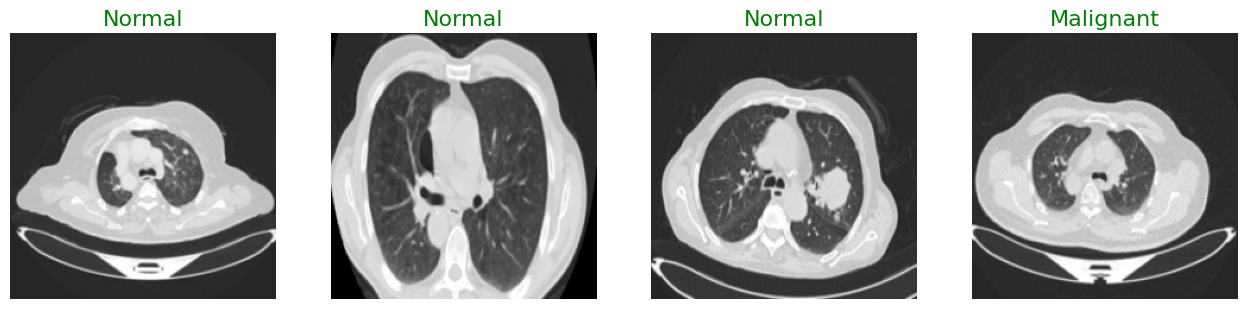

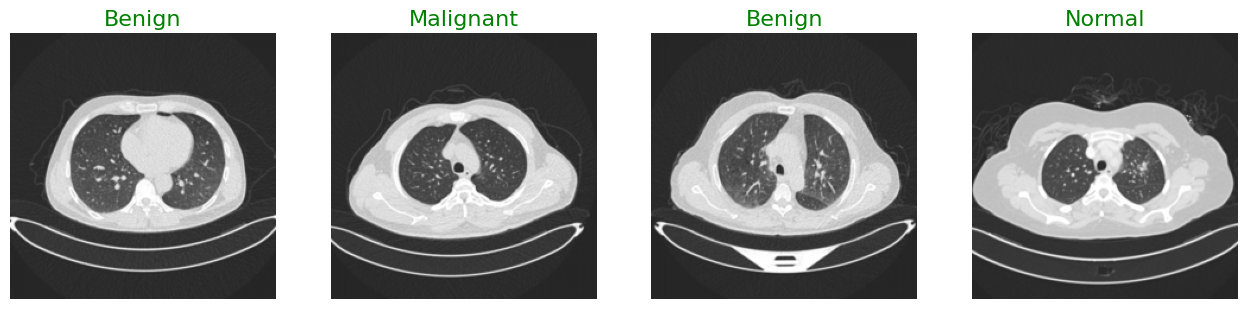

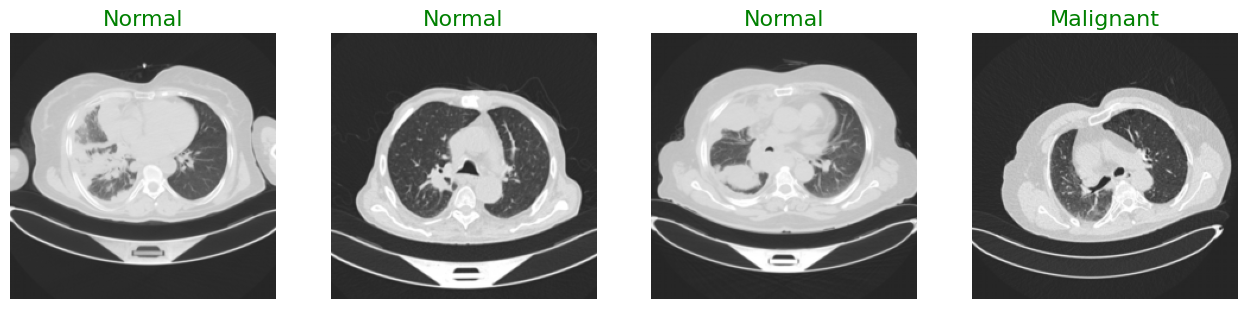

In [ ]:
#@title **3.2 Visualising the Data Loaders - Transforms 1**

import matplotlib.pyplot as plt
import numpy as np

def display_sample_images(data_loader, num_images=5):
    # Get a batch of images and labels from the data loader
    images, labels = next(iter(data_loader))
    images = images / 2 + 0.5  # Undo the normalization (from [-1, 1] to [0, 1])
    images = torch.clamp(images, 0, 1)  # Clip values to [0, 1] range
    # Convert the images to NumPy format
    images = images.numpy()
    # Setup the plot
    plt.figure(figsize=(20, 20))

    for i in range(min(num_images, len(labels))):
        plt.subplot(5, 5, i + 1)  # 5x5 grid for up to 25 images
        img = np.transpose(images[i], (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.imshow(img)
        plt.title(f"{ID_to_label[labels[i].item()].capitalize()}", color="green", fontsize=16)
        plt.axis('off')

    plt.show()

display_sample_images(train, num_images=5)
display_sample_images(test, num_images=5)
display_sample_images(val, num_images=5)

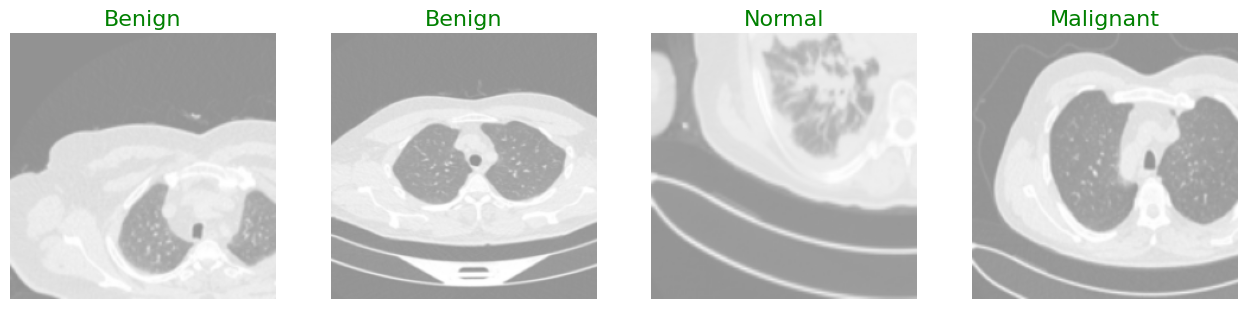

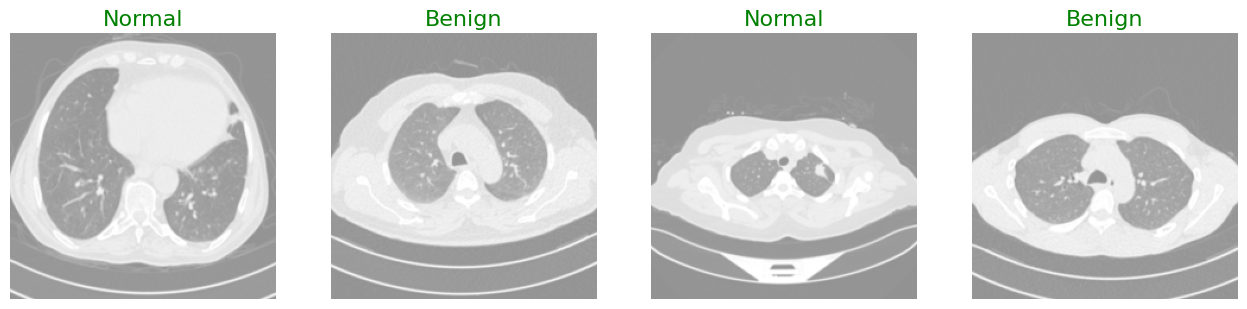

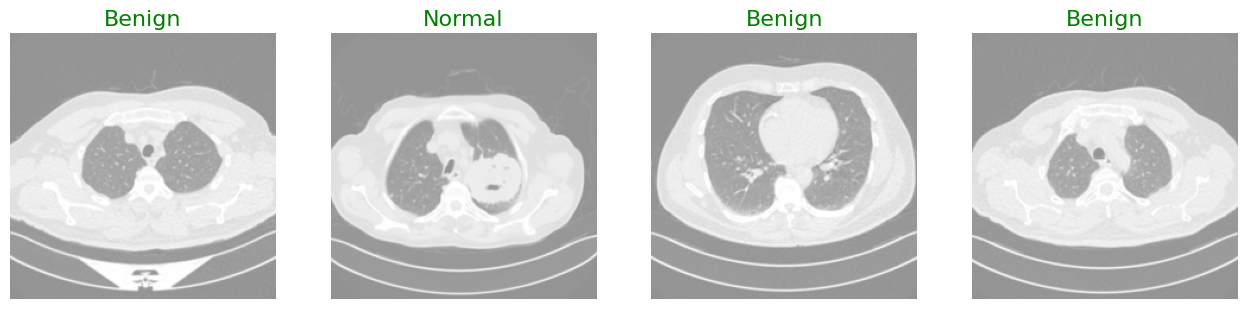

In [ ]:
#@title **3.2 Visualising the Data Loaders - Transforms 2**

display_sample_images(normal_train, num_images=5)
display_sample_images(normal_test, num_images=5)
display_sample_images(normal_val, num_images=5)

# **4. Training Analysis**

In [ ]:
#@title **5.1.1 Device**

# Initialised Early - Needed for Misclassification Handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title **5.1.2 EarlyStopping Callback**

# EarlyStopping class to stop training if no improvement after a given patience
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait before stopping when validation loss is not improving.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.counter = 0  # reset the counter if validation loss improves
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

### **5.1.3 Misclassification Handling**

#### **5.1.3.1 Visualising Misclassification - Distribution Graphs for Dataframes**

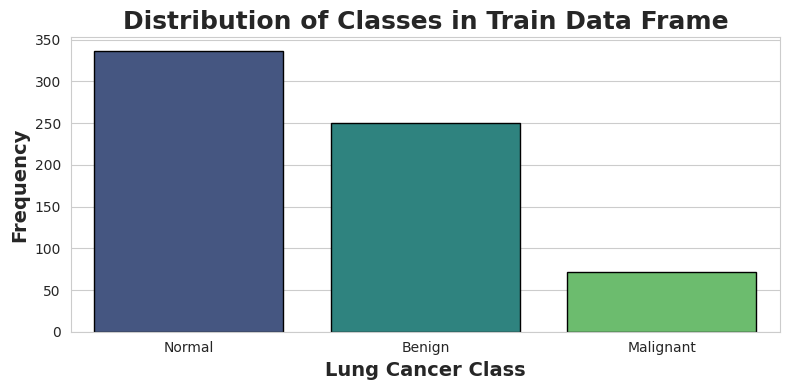

In [ ]:
#@title **(a) Distribution Graph: train_df**
attribute = 'labels'
title = 'Distribution of Classes in Train Data Frame'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

plot_distribution(train_df, attribute, title, x_label, y_label)

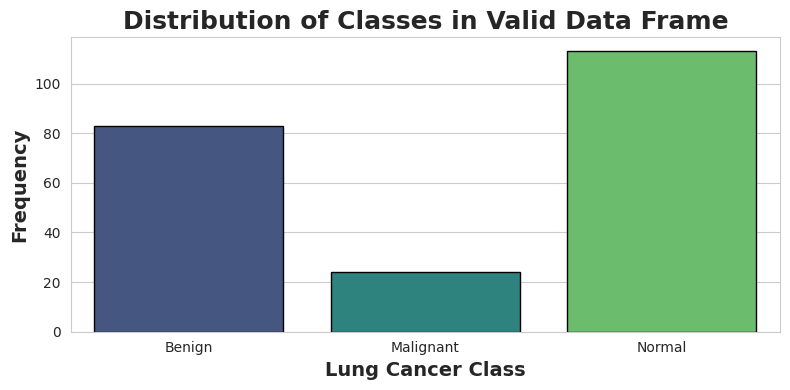

In [ ]:
#@title **(b) Distribution Graph: val_df**
attribute = 'labels'
title = 'Distribution of Classes in Valid Data Frame'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

plot_distribution(val_df, attribute, title, x_label, y_label)

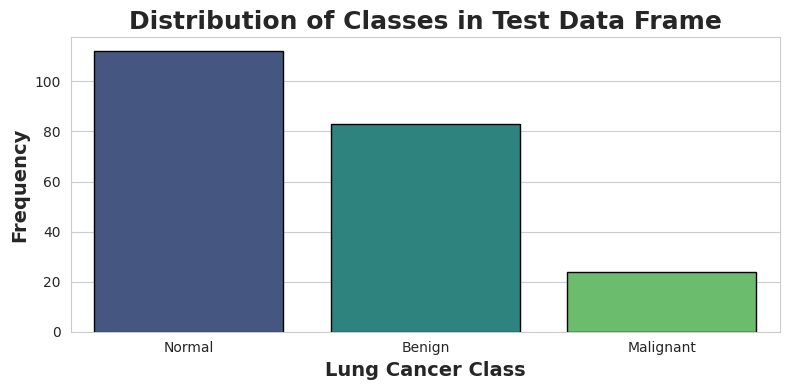

In [ ]:
#@title **(c) Distribution Graph: test_df**
attribute = 'labels'
title = 'Distribution of Classes in Test Data Frame'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

plot_distribution(test_df, attribute, title, x_label, y_label)

#### **5.1.3.2 Handling Misclassification**

**How to handle the imbalance of the distrbution of classes?**
We can compute weights for the Loss Function,

In [ ]:
from collections import Counter
import torch

# NOTE:
# need to recalculate weights for optimizer
# Convert label to tensor (use the same label mapping)
# label_to_ID = {"benign": 0, "malignant": 1, "normal": 2}
# ID_to_label = {0: "benign", 1: "malignant", 2: "normal"}

def get_weights(df):
    labels = df.iloc[:, 1].map(label_to_ID)
    label_counts = Counter(labels)
    total_samples = len(labels)
    print(f"Label Frequencies in Dataframe: {label_counts}")

    num_classes = len(label_to_ID)
    class_weights = []

    # Calculate the weight for each class (inversely proportional to its frequency)
    for ID in label_counts.keys():
        class_weight = total_samples / (num_classes * label_counts[ID])
        class_weights.append(class_weight)

    # Convert to a PyTorch Tensor
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    print(f"Class Weights: {class_weights}\n")

    return class_weights

# higher weights are assigned to labels with lower count
train_weights = get_weights(train_df)
val_weights = get_weights(val_df)
test_weights = get_weights(test_df)

def get_universal_weight():
    # Average the weights from training, validation, and testing
    universal_weight = (train_weights + val_weights + test_weights) / 3
    print(f"Universal Class Weights: {universal_weight}")
    return universal_weight

universal_weight = get_universal_weight()

Label Frequencies in Dataframe: Counter({2: 336, 0: 250, 1: 72})
Class Weights: tensor([0.6528, 0.8773, 3.0463], device='cuda:0')

Label Frequencies in Dataframe: Counter({2: 113, 0: 83, 1: 24})
Class Weights: tensor([0.8835, 3.0556, 0.6490], device='cuda:0')

Label Frequencies in Dataframe: Counter({2: 112, 0: 83, 1: 24})
Class Weights: tensor([0.6518, 0.8795, 3.0417], device='cuda:0')

Universal Class Weights: tensor([0.7294, 1.6041, 2.2456], device='cuda:0')
